<a href="https://colab.research.google.com/github/Sibidine/Image-Classifier/blob/main/Happy_Sad_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup and Load data

## 1.1 Install dependencies and Setup

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [ ]:
import tensorflow as tf
import os

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.2 remove bad data

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir = 'drive/MyDrive/data'

In [ ]:
img_exts = ['jpeg','jpg','bmp','png']

(The script below iterates through every clas in the directory mentioned by `data_dir`. For each class, it iterates through every image and stores the path of the image in `image_path`. `OpenCV` is used to read the image as a `NumPy` array, and `imghdr` checks if the image extension is valid, against the `img_exts` list. If not, it gets removed from the folder.)

In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class, image)
    try:
      img = cv2.imread(image_path) 
      tip = imghdr.what(image_path)
      if tip not in img_exts:
        print ('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

## 1.3 Load data

`Dataset` allows us to build a data pipeline, allowing for scalability and a repeatable set of steps

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

The below API handles preprocessing as well

In [ ]:
data= tf.keras.utils.image_dataset_from_directory(data_dir)

Found 305 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

Gets another batch from the iterator

In [ ]:
batch = data_iterator.next()

The `batch` has a length of 2- the first part contains the images as `NumPy` arrays, the second contains their labels.

In [ ]:
len(batch)
batch[0].shape

(32, 256, 256, 3)

For visualisation of batches- lets us see what each label denotes

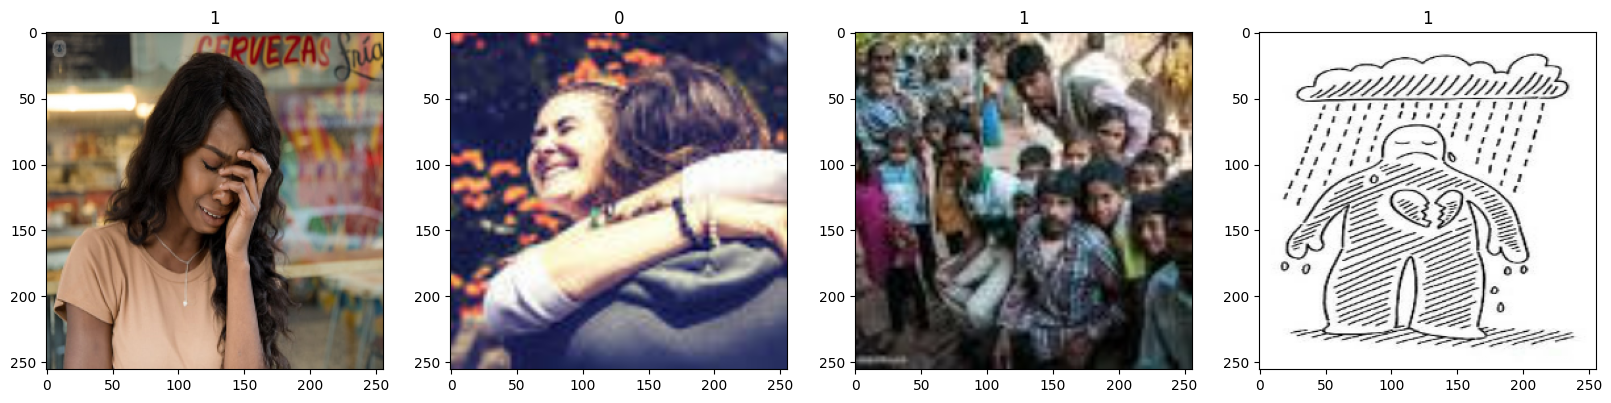

In [ ]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

# 2. Preprocess Data

## 2.1 Scale Data

Working woth data ranging from 0 to 1 is ideal, so we scale the data as we're loading it in from the pipeline.

In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
data.as_numpy_iterator().next()

## 2.2 Split Data

In [ ]:
len(data)

10

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3. Deep Model

## 3.1 Build Deep Learning Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


In [ ]:
model = Sequential()

In [ ]:
model = Sequential([

    # convolutional base
    layers.Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)),
    layers.MaxPool2D(),

    layers.Conv2D(32,(3,3),1,activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(16,(3,3),1,activation='relu'),
    layers.MaxPool2D(),

    layers.Flatten(),

    # Dense head
    layers.Dense(256,activation = 'relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1,activation = 'sigmoid')
])

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [ ]:

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 30, 30, 16)     

## 3.2 Train

In [ ]:
logdir = 'drive/MyDrive/logs'

In [ ]:
callback  = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
hist = model.fit(
    train,
    epochs=20,
    validation_data = val,
    callbacks = [callback]
)

Epoch 1/20
7/7 [==============================] - 9s 773ms/step - loss: 0.7656 - binary_accuracy: 0.4464 - val_loss: 0.6498 - val_binary_accuracy: 0.7969
Epoch 2/20
7/7 [==============================] - 6s 568ms/step - loss: 0.6463 - binary_accuracy: 0.6786 - val_loss: 0.6408 - val_binary_accuracy: 0.5469
Epoch 3/20
7/7 [==============================] - 7s 769ms/step - loss: 0.5552 - binary_accuracy: 0.7143 - val_loss: 0.4553 - val_binary_accuracy: 0.8750
Epoch 4/20
7/7 [==============================] - 6s 542ms/step - loss: 0.5164 - binary_accuracy: 0.8080 - val_loss: 0.4657 - val_binary_accuracy: 0.8281
Epoch 5/20
7/7 [==============================] - 7s 563ms/step - loss: 0.4438 - binary_accuracy: 0.7991 - val_loss: 0.3242 - val_binary_accuracy: 0.8438
Epoch 6/20
7/7 [==============================] - 7s 747ms/step - loss: 0.3846 - binary_accuracy: 0.8482 - val_loss: 0.2645 - val_binary_accuracy: 0.9531
Epoch 7/20
7/7 [==============================] - 6s 541ms/step - loss: 0.24

## 3.3 Plot performance

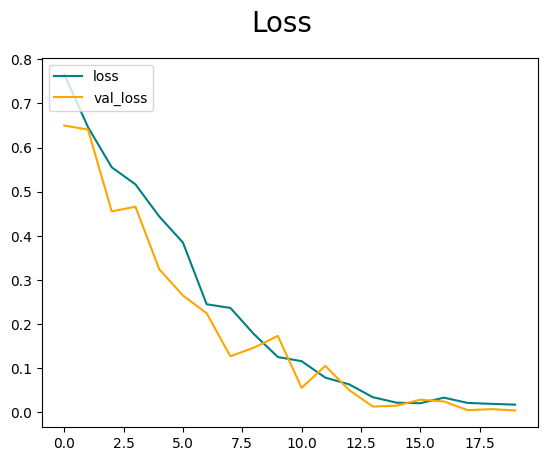

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

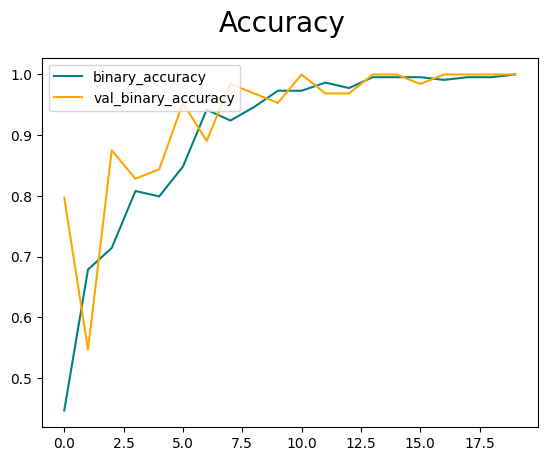

In [ ]:
fig = plt.figure()
plt.plot(hist.history['binary_accuracy'], color='teal', label='binary_accuracy')
plt.plot(hist.history['val_binary_accuracy'], color='orange', label='val_binary_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()



#4. Evaluate Performance

##4.1 Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 28ms/step


##4.2 Test

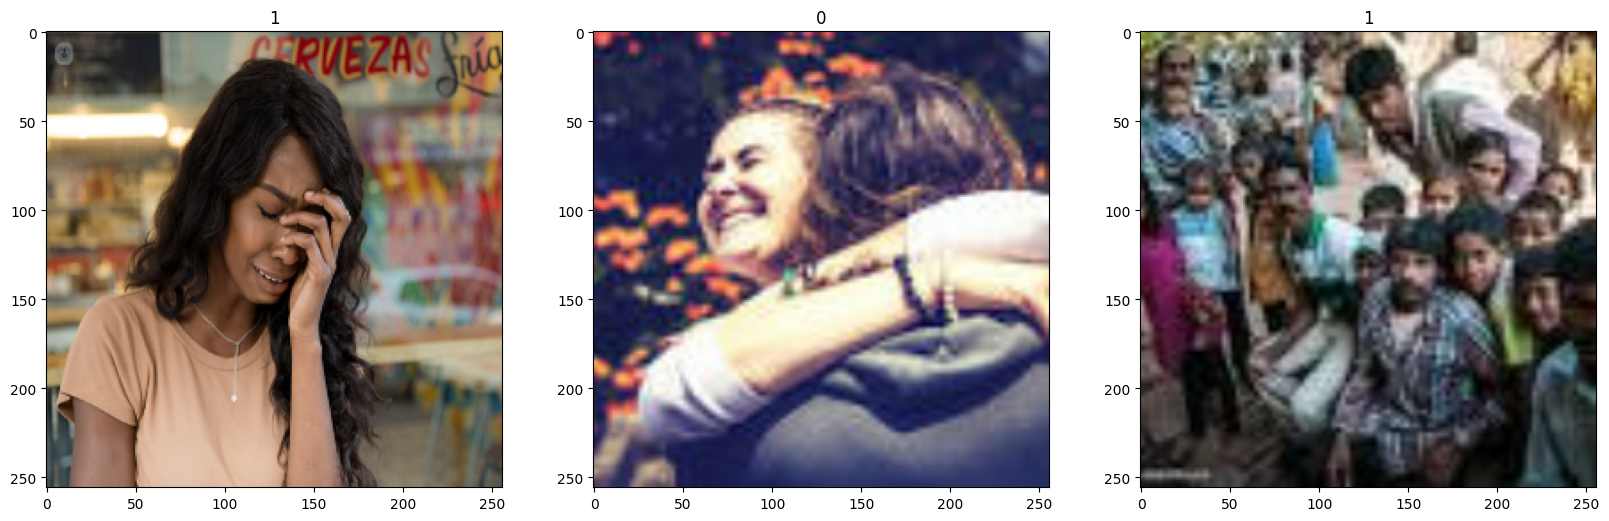

In [ ]:
fig,ax = plt.subplots(ncols=3,figsize=(20,20))
for idx,img in enumerate(batch[0][:3]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

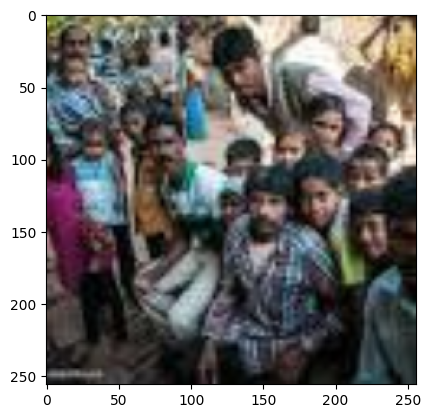

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy())
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 31ms/step


In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
